# New York City Taxi Fare Exploratory Data Analysis and Prediction

This notebook displays my exploration of the NYC Taxi Fare dataset.

## Data and Tools Upload

In [1]:
# Import necessary libaries for analysis
import datetime
import pytz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point
plt.style.use('ggplot')

To conduct exploratory data analysis, the original train, test, and validation datasets were combined then re-split prior to model training and evaluation.

In [2]:
# Read data into pandas dataframe
df_cols = ['fare_amount','pickup_datetime','pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude','passenger_count','id']
train_df = pd.read_csv('../input/taxi-trip-data/taxi-train.csv', names=df_cols, header=None).drop(columns=['id'])
test_df = pd.read_csv('../input/taxi-trip-data/taxi-test.csv', names=df_cols, header=None).drop(columns=['id'])
valid_df = pd.read_csv('../input/taxi-trip-data/taxi-valid.csv', names=df_cols, header=None).drop(columns=['id'])
all_df = pd.concat([train_df, test_df, valid_df]).reset_index(drop=True)
all_df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,11.3,2011-01-28 20:42:59 UTC,-73.999022,40.739146,-73.990369,40.717866,1
1,7.7,2011-06-27 04:28:06 UTC,-73.987443,40.729221,-73.979013,40.758641,1
2,10.5,2011-04-03 00:54:53 UTC,-73.982539,40.735725,-73.954797,40.778388,1
3,16.2,2009-04-10 04:11:56 UTC,-74.001945,40.740505,-73.913850,40.758559,1
4,33.5,2014-02-24 18:22:00 UTC,-73.993372,40.753382,-73.860900,40.732897,2
...,...,...,...,...,...,...,...
10471,13.0,2014-12-08 21:50:00 UTC,-73.990998,40.760407,-73.994448,40.724722,1
10472,8.5,2013-04-18 08:48:00 UTC,-73.958592,40.772227,-73.972010,40.765507,3
10473,8.1,2009-12-07 20:49:00 UTC,-74.007522,40.726010,-73.997475,40.754783,2
10474,13.3,2011-03-19 03:32:00 UTC,-74.006455,40.739547,-73.973455,40.795385,1


In [3]:
# Check data types
all_df.dtypes

fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [4]:
# Check statistics of features
all_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000
mean,11.349003,-73.975206,40.751526,-73.974373,40.751199,1.653303
std,9.878630,0.038547,0.029187,0.039086,0.033147,1.278827
min,2.500000,-74.258183,40.452290,-74.260472,40.417750,1.000000
25%,6.000000,-73.992336,40.737600,-73.991739,40.735904,1.000000
50%,8.500000,-73.982090,40.754020,-73.980780,40.753597,1.000000
75%,12.500000,-73.968517,40.767774,-73.965851,40.767921,2.000000
max,179.000000,-73.137393,41.366138,-73.137393,41.366138,6.000000


**Key Takeaway:** Fare amount seems to to be right skewed with an average fare of 11.35 and the standard deviation of 9.88

## Initial Data Engineering & Visualization

This section explores the distribution of data points across different factors (fare amount, date/time, pickup location, dropoff location)

In [5]:
# Convert pickup_datetime column to datetime object
all_df['pickup_datetime'] = pd.to_datetime(all_df['pickup_datetime'])
all_df.reset_index(drop=True, inplace=True)
all_df.dtypes

fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

The timezone is set as UTC, which does not match NYC's timezone

In [6]:
# Convert timezone from UTC to EST/EDT
all_df['pickup_datetime'] = all_df['pickup_datetime'].apply(lambda x: x.tz_convert('America/New_York'))
all_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,11.3,2011-01-28 15:42:59-05:00,-73.999022,40.739146,-73.990369,40.717866,1
1,7.7,2011-06-27 00:28:06-04:00,-73.987443,40.729221,-73.979013,40.758641,1
2,10.5,2011-04-02 20:54:53-04:00,-73.982539,40.735725,-73.954797,40.778388,1
3,16.2,2009-04-10 00:11:56-04:00,-74.001945,40.740505,-73.913850,40.758559,1
4,33.5,2014-02-24 13:22:00-05:00,-73.993372,40.753382,-73.860900,40.732897,2


In [7]:
# Get dummies for day of the week from pickup datetime
def day_of_week_encoding(df):
    df['pickup_dayoftheweek'] = df['pickup_datetime'].dt.day_name()
    day_dummies = pd.get_dummies(df['pickup_dayoftheweek'], prefix='day')
    df = pd.concat([df, day_dummies], axis=1)
    return df

all_df = day_of_week_encoding(all_df)
all_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_dayoftheweek,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,11.3,2011-01-28 15:42:59-05:00,-73.999022,40.739146,-73.990369,40.717866,1,Friday,True,False,False,False,False,False,False
1,7.7,2011-06-27 00:28:06-04:00,-73.987443,40.729221,-73.979013,40.758641,1,Monday,False,True,False,False,False,False,False
2,10.5,2011-04-02 20:54:53-04:00,-73.982539,40.735725,-73.954797,40.778388,1,Saturday,False,False,True,False,False,False,False
3,16.2,2009-04-10 00:11:56-04:00,-74.001945,40.740505,-73.913850,40.758559,1,Friday,True,False,False,False,False,False,False
4,33.5,2014-02-24 13:22:00-05:00,-73.993372,40.753382,-73.860900,40.732897,2,Monday,False,True,False,False,False,False,False


In [8]:
# Get averages fares for each day of the week
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_avg_fare = all_df.groupby('pickup_dayoftheweek').mean()[['fare_amount']]
daily_avg_fare = daily_avg_fare.reindex(ordered_days)
daily_avg_fare

,fare_amount
pickup_dayoftheweek,
Monday,11.741661
Tuesday,10.951066
Wednesday,10.834184
Thursday,10.728569
Friday,11.967445
Saturday,11.770843
Sunday,11.726983


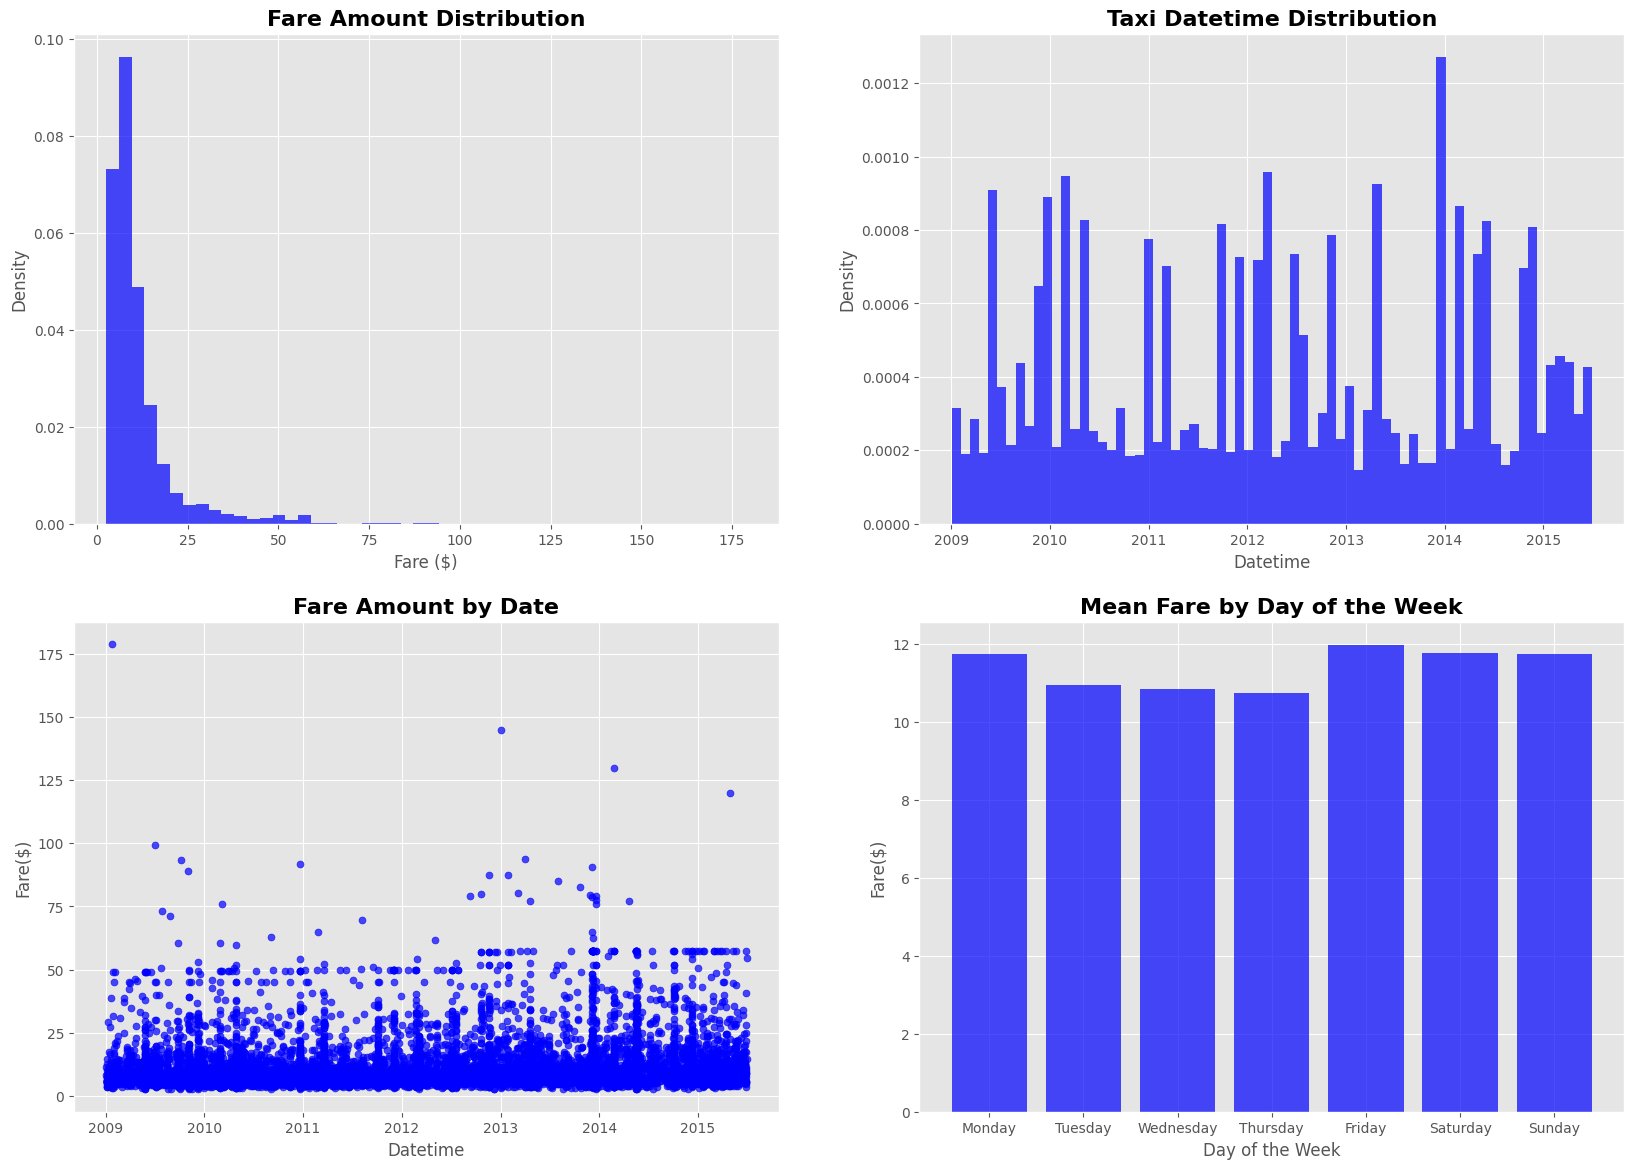

In [9]:
# Plot fare amount distribution, pickup datetime distribution, fare amounts by datetime, and average fare amount by day of the week
fig, ax = plt.subplots(2,2,figsize=(20,14))

ax[0, 0].hist(all_df['fare_amount'], bins=50, color='blue', alpha=0.7, density=True)
ax[0, 0].set_xlabel('Fare ($)', fontsize=12)
ax[0, 0].set_ylabel('Density', fontsize=12)
ax[0, 0].set_title('Fare Amount Distribution', fontsize=16, fontweight='bold')

ax[0, 1].hist(all_df['pickup_datetime'], bins=70, color='blue', alpha=0.7, density=True)
ax[0, 1].set_xlabel('Datetime', fontsize=12)
ax[0, 1].set_ylabel('Density', fontsize=12)
ax[0, 1].set_title('Taxi Datetime Distribution', fontsize=16, fontweight='bold')

ax[1, 0].scatter(all_df['pickup_datetime'], all_df['fare_amount'], s=25, alpha=0.7, color = 'blue')
ax[1, 0].set_xlabel('Datetime', fontsize=12)
ax[1, 0].set_ylabel('Fare($)', fontsize=12)
ax[1, 0].set_title("Fare Amount by Date", fontsize=16, fontweight='bold')

ax[1, 1].bar(daily_avg_fare.index, daily_avg_fare['fare_amount'], alpha=0.7, color = 'blue')
ax[1, 1].set_xlabel('Day of the Week', fontsize=12)
ax[1, 1].set_ylabel('Fare($)', fontsize=12)
ax[1, 1].set_title("Mean Fare by Day of the Week", fontsize=16, fontweight='bold')


plt.show()

**Key Takeaways:**
* As expected, the fare amount is right skewed
* There is no clear pattern in the datetime distribution of taxi trips
* There is no clear correlation between the datetime and fare amount
* There is no clear correlation between the day of the week and fare amount

In [10]:
def get_year(df):
    df['pickup_year'] = df['pickup_datetime'].dt.year
    df['pickup_year'] = df['pickup_year']
    return df

all_df = get_year(all_df)
all_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_dayoftheweek,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,pickup_year
0,11.3,2011-01-28 15:42:59-05:00,-73.999022,40.739146,-73.990369,40.717866,1,Friday,True,False,False,False,False,False,False,2011
1,7.7,2011-06-27 00:28:06-04:00,-73.987443,40.729221,-73.979013,40.758641,1,Monday,False,True,False,False,False,False,False,2011
2,10.5,2011-04-02 20:54:53-04:00,-73.982539,40.735725,-73.954797,40.778388,1,Saturday,False,False,True,False,False,False,False,2011
3,16.2,2009-04-10 00:11:56-04:00,-74.001945,40.740505,-73.913850,40.758559,1,Friday,True,False,False,False,False,False,False,2009
4,33.5,2014-02-24 13:22:00-05:00,-73.993372,40.753382,-73.860900,40.732897,2,Monday,False,True,False,False,False,False,False,2014


In [11]:
yearly_avg_fare = all_df[['fare_amount','pickup_year']].groupby('pickup_year').mean()
yearly_avg_fare

,fare_amount
pickup_year,
2009,10.224617
2010,10.281906
2011,10.171135
2012,11.167167
2013,13.120140
2014,12.586475
2015,12.122237


In [12]:
# Convert Latitude & Longitude Values To Geometry Objects
def get_geometry(df):
    pickup_df = pd.DataFrame({'pickup_geometry': df.apply(lambda x: Point((x.pickup_longitude, x.pickup_latitude)), axis=1)})
    dropoff_df = pd.DataFrame({'dropoff_geometry': df.apply(lambda x: Point((x.dropoff_longitude, x.dropoff_latitude)), axis=1)})
    pickup_gpd = gpd.GeoDataFrame(pickup_df, geometry='pickup_geometry')
    dropoff_gpd = gpd.GeoDataFrame(dropoff_df, geometry='dropoff_geometry')
    pickup_gpd = pickup_gpd.set_crs("EPSG:4326")
    dropoff_gpd = dropoff_gpd.set_crs("EPSG:4326")
    return pickup_gpd, dropoff_gpd

In [13]:
pickup_gpd, dropoff_gpd = get_geometry(all_df)
print(pickup_gpd.head())
print(dropoff_gpd.head())

/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:131: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:131: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


              pickup_geometry
0  POINT (-73.99902 40.73915)
1  POINT (-73.98744 40.72922)
2  POINT (-73.98254 40.73573)
3  POINT (-74.00195 40.74050)
4  POINT (-73.99337 40.75338)
             dropoff_geometry
0  POINT (-73.99037 40.71787)
1  POINT (-73.97901 40.75864)
2  POINT (-73.95480 40.77839)
3  POINT (-73.91385 40.75856)
4  POINT (-73.86090 40.73290)


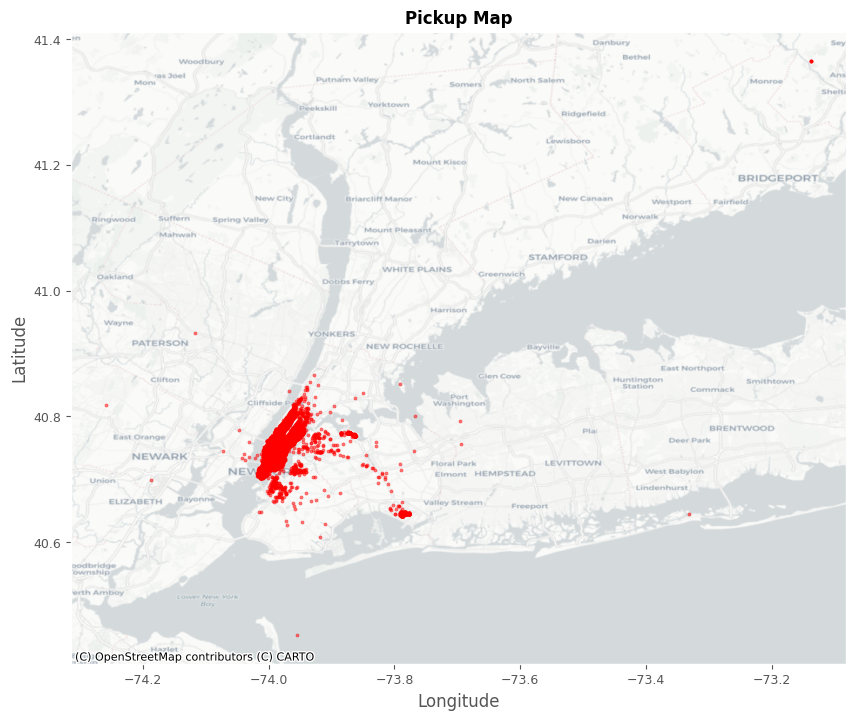

In [14]:
# Plot Pickup Locations
fig, ax = plt.subplots(figsize=(10,10))
pu_map = pickup_gpd.plot(ax=ax, markersize=5, color='red', alpha=0.5)
cx.add_basemap(ax, crs=pickup_gpd.crs.to_string(), source=cx.providers.CartoDB.Positron)
pu_map.tick_params(axis='x', labelsize=9)
pu_map.tick_params(axis='y', labelsize=9)
pu_map.set_xlabel("Longitude")
pu_map.set_ylabel("Latitude")
pu_map.set_title("Pickup Map", fontsize=12, fontweight='bold')
ax.grid(False)
plt.show()

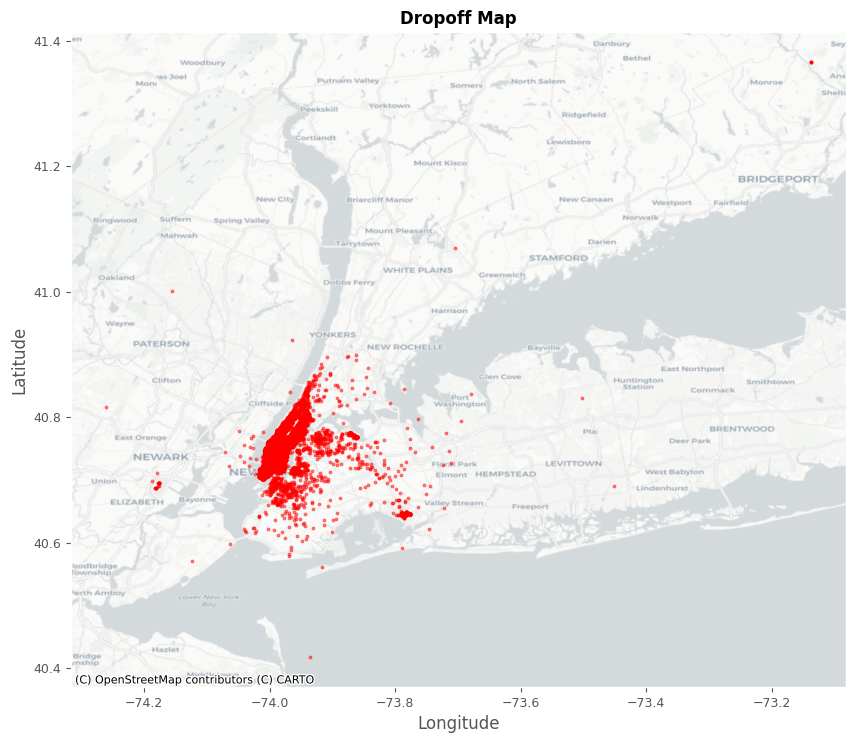

In [15]:
# Plot Dropoff Locations
fig, ax = plt.subplots(figsize=(10,10))
do_map = dropoff_gpd.plot(ax=ax, markersize=5, color='red', alpha=0.5)
cx.add_basemap(ax, crs=dropoff_gpd.crs.to_string(), source=cx.providers.CartoDB.Positron)
do_map.tick_params(axis='x', labelsize=9)
do_map.tick_params(axis='y', labelsize=9)
do_map.set_xlabel("Longitude")
do_map.set_ylabel("Latitude")
do_map.set_title("Dropoff Map", fontsize=12, fontweight='bold')
ax.grid(False)
plt.show()

**Key Takeaway:** The pickup and dropoff locations are heavily focused within Manhattan, Queens, and Brooklyn

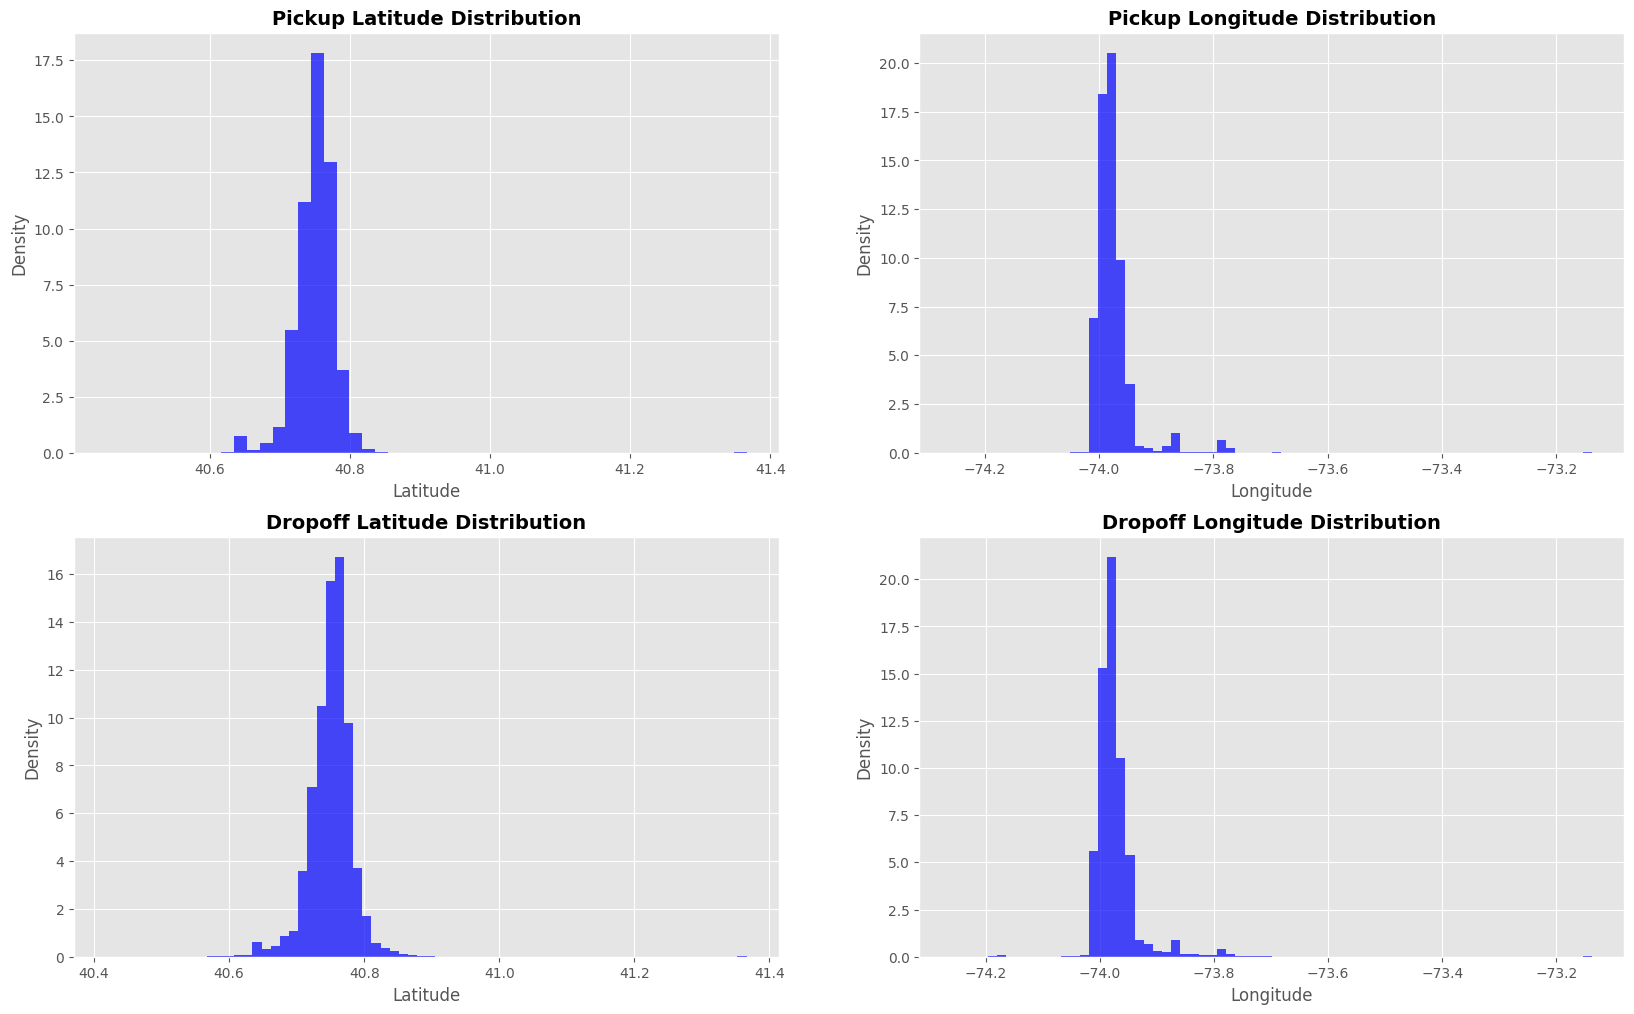

In [16]:
# Plot distribution of latitude and longitude values
fig, ax = plt.subplots(2,2,figsize=(20,12))

ax[0, 0].hist(all_df['pickup_latitude'], bins=50, color='blue', alpha=0.7, density=True)
ax[0, 0].set_xlabel('Latitude', fontsize=12)
ax[0, 0].set_ylabel('Density', fontsize=12)
ax[0, 0].set_title('Pickup Latitude Distribution', fontsize=14, fontweight='bold')

ax[0, 1].hist(all_df['pickup_longitude'], bins=70, color='blue', alpha=0.7, density=True)
ax[0, 1].set_xlabel('Longitude', fontsize=12)
ax[0, 1].set_ylabel('Density', fontsize=12)
ax[0, 1].set_title('Pickup Longitude Distribution', fontsize=14, fontweight='bold')

ax[1, 0].hist(all_df['dropoff_latitude'], bins=70, color='blue', alpha=0.7, density=True)
ax[1, 0].set_xlabel('Latitude', fontsize=12)
ax[1, 0].set_ylabel('Density', fontsize=12)
ax[1, 0].set_title('Dropoff Latitude Distribution', fontsize=14, fontweight='bold')

ax[1, 1].hist(all_df['dropoff_longitude'], bins=70, color='blue', alpha=0.7, density=True)
ax[1, 1].set_xlabel('Longitude', fontsize=12)
ax[1, 1].set_ylabel('Density', fontsize=12)
ax[1, 1].set_title('Dropoff Longitude Distribution', fontsize=14, fontweight='bold')


plt.show()

## Data Cleaning & Visualization

In [17]:
# Remove Extreme Outliers & Trips With Identical Pickup and Dropoff Locations
all_df.drop(all_df[(all_df['pickup_latitude'] == all_df['dropoff_latitude']) & (all_df['pickup_longitude'] == all_df['dropoff_longitude'])].index, inplace=True)
all_df.drop(all_df[(all_df['pickup_latitude'] >= 41) | all_df['dropoff_latitude'] >= 41].index, inplace=True)
all_df.drop(all_df[(all_df['pickup_longitude'] >= -73.6) | (all_df['dropoff_longitude'] >= -73.6)].index, inplace=True)
all_df.drop(all_df[(all_df['pickup_latitude'] <= 40.5) | (all_df['dropoff_latitude'] <= 40.5)].index, inplace=True)

# Remove Trips with Pickup or Dropoff Locations In Bodies of Water
all_df.drop(index=[2991,5309,10251], inplace=True)

In [18]:
pickup_gpd_cleaned, dropoff_gpd_cleaned = get_geometry(all_df)

/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:131: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:131: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


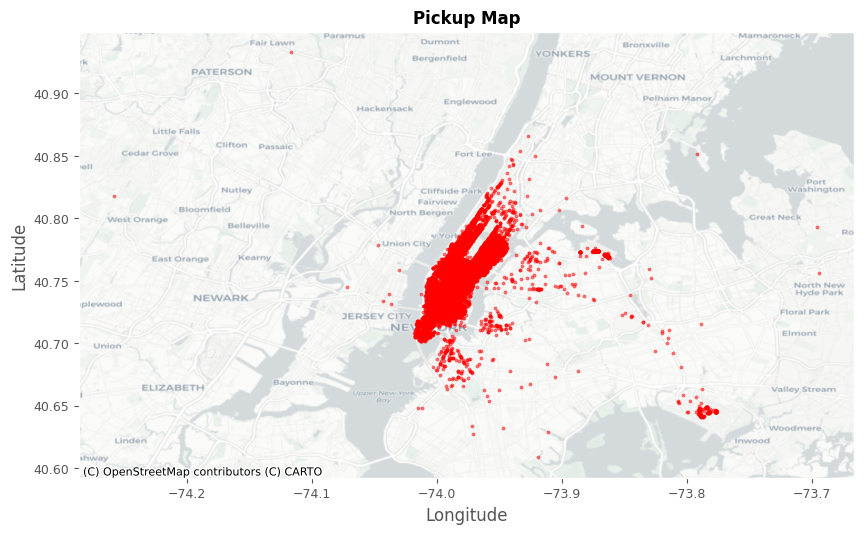

In [19]:
# Plot Pickup Locations After Cleaning
fig, ax = plt.subplots(figsize=(10,10))
pu_map = pickup_gpd_cleaned.plot(ax=ax, markersize=5, color='red', alpha=0.5)
cx.add_basemap(ax, crs=pickup_gpd.crs.to_string(), source=cx.providers.CartoDB.Positron)
pu_map.tick_params(axis='x', labelsize=9)
pu_map.tick_params(axis='y', labelsize=9)
pu_map.set_xlabel("Longitude")
pu_map.set_ylabel("Latitude")
pu_map.set_title("Pickup Map", fontsize=12, fontweight='bold')
ax.grid(False)
plt.show()

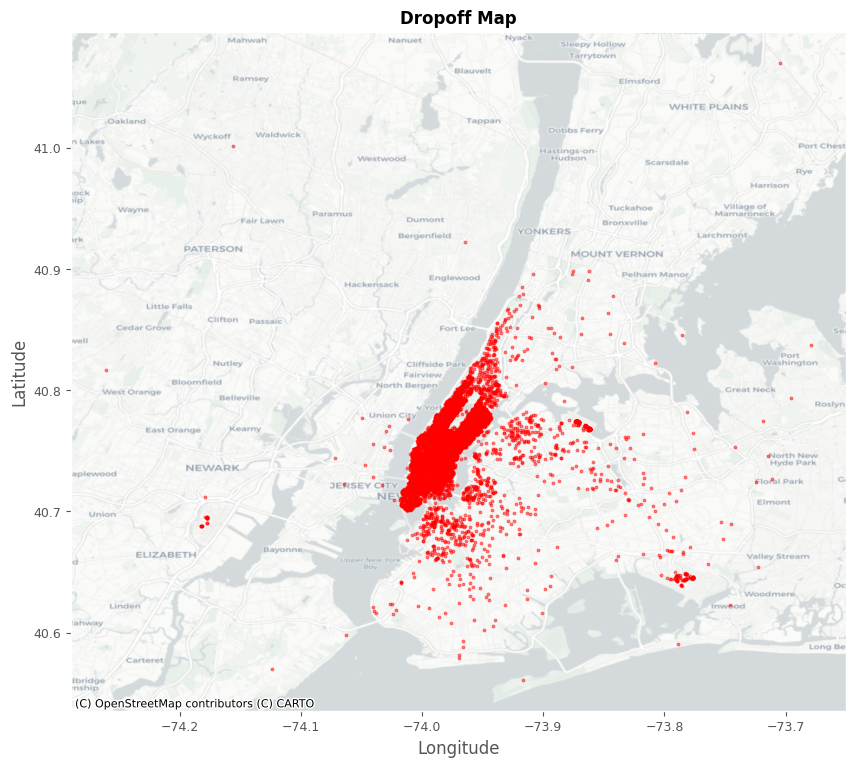

In [20]:
# Plot Dropoff Locations After Removing Outliers
fig, ax = plt.subplots(figsize=(10,10))
do_map = dropoff_gpd_cleaned.plot(ax=ax, markersize=5, color='red', alpha=0.5)
cx.add_basemap(ax, crs=dropoff_gpd.crs.to_string(), source=cx.providers.CartoDB.Positron)
do_map.tick_params(axis='x', labelsize=9)
do_map.tick_params(axis='y', labelsize=9)
do_map.set_xlabel("Longitude")
do_map.set_ylabel("Latitude")
do_map.set_title("Dropoff Map", fontsize=12, fontweight='bold')
ax.grid(False)
plt.show()

In [21]:
# Load in NYC Boroughs Shapefile
nyc = gpd.read_file('../input/nyc-shapefile/geo_export_8fa447e4-1d62-4164-9635-24c69774a066.shp')
nyc = nyc.to_crs("EPSG:4326")
nyc

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."
...,...,...,...,...,...,...,...
258,Brooklyn,256.0,256.0,0.000169,0.067915,Williamsburg (South Side),"POLYGON ((-73.95834 40.71331, -73.95681 40.712..."
259,Bronx,259.0,259.0,0.000395,0.126750,Woodlawn/Wakefield,"POLYGON ((-73.85107 40.91037, -73.85207 40.909..."
260,Queens,260.0,260.0,0.000422,0.133514,Woodside,"POLYGON ((-73.90175 40.76078, -73.90147 40.759..."
261,Manhattan,261.0,261.0,0.000034,0.027120,World Trade Center,"POLYGON ((-74.01333 40.70503, -74.01327 40.704..."


In [22]:
# Get Counts for Pickups and Dropoffs in Regions Within NYC Boroughs
pu_join = gpd.sjoin(pickup_gpd_cleaned, nyc, how='left', predicate='within')
do_join = gpd.sjoin(dropoff_gpd_cleaned, nyc, how='left', predicate='within')
pus = pu_join['location_i'].value_counts().sort_index()
dos = do_join['location_i'].value_counts().sort_index()
data = []
pu_nyc = pd.concat([pd.DataFrame(data), nyc], ignore_index=True)
do_nyc = pd.concat([pd.DataFrame(data), nyc], ignore_index=True)
pu_nyc['Count'] = pus
do_nyc['Count'] = dos
pu_nyc = gpd.GeoDataFrame(pu_nyc)
do_nyc = gpd.GeoDataFrame(do_nyc)

Text(0.5, 1.0, 'Pickups In NYC Boroughs')

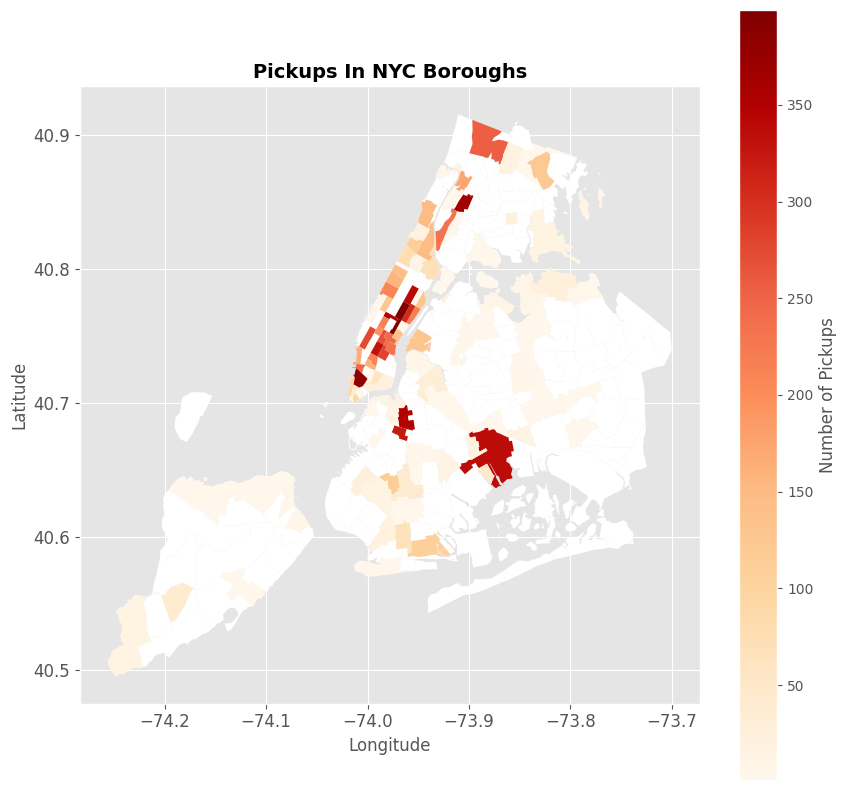

In [23]:
# Plot Pickups in NYC Boroughs
f, ax = plt.subplots(figsize =(10,10))
nyc.plot(ax=ax, color='white')
pu_map = pu_nyc.plot(ax=ax,column='Count', cmap='OrRd', legend = True, legend_kwds={'label': "Number of Pickups"})
pu_map.tick_params(axis='x', labelsize=12)
pu_map.tick_params(axis='y', labelsize=12)
pu_map.set_xlabel("Longitude")
pu_map.set_ylabel("Latitude")
pu_map.set_title("Pickups In NYC Boroughs", fontsize=14, fontweight='bold')

Text(0.5, 1.0, 'Dropoffs In NYC Boroughs')

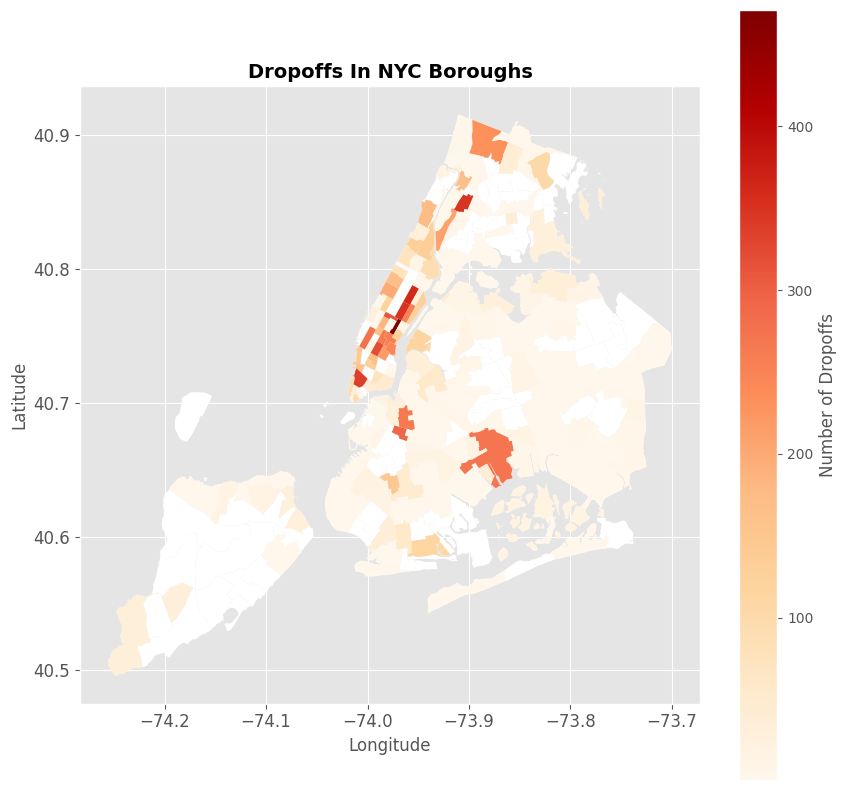

In [24]:
# Plot Dropoffs in NYC Boroughs
f, ax = plt.subplots(figsize =(10,10))
nyc.plot(ax=ax, color='white')
do_map = do_nyc.plot(ax = ax, column='Count', cmap='OrRd', legend = True, legend_kwds={'label': "Number of Dropoffs"})
do_map.tick_params(axis='x', labelsize=12)
do_map.tick_params(axis='y', labelsize=12)
do_map.set_xlabel("Longitude")
do_map.set_ylabel("Latitude")
do_map.set_title("Dropoffs In NYC Boroughs", fontsize=14, fontweight='bold')

In [25]:
all_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year
count,10371.000000,10371.000000,10371.000000,10371.000000,10371.000000,10371.000000,10371.000000
mean,11.332512,-73.975804,40.751359,-73.974970,40.751015,1.653360,2011.813711
std,9.809118,0.033830,0.026306,0.034414,0.030665,1.279496,1.899045
min,2.500000,-74.258183,40.608573,-74.260472,40.561076,1.000000,2009.000000
25%,6.000000,-73.992370,40.737667,-73.991760,40.736022,1.000000,2010.000000
50%,8.500000,-73.982125,40.754068,-73.980826,40.753637,1.000000,2012.000000
75%,12.500000,-73.968734,40.767748,-73.966061,40.767901,2.000000,2013.000000
max,179.000000,-73.694077,40.933269,-73.679133,41.070332,6.000000,2015.000000


After removing location-based outliers and trips with locations in bodies of water, the standard deviation has decreased from 9.88 to 9.81.

## Feature Engineering

In [26]:
!pip install tensorflow==2.11

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.2 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 21.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 3.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 20.7 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 6.5 MB/s eta 0:00:00:00:01
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninst

In [27]:
# Import ML libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow import feature_column as fc
from tensorflow.keras.layers import Input, Dense, Concatenate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [28]:
# Baseline Model Feature Engineering Functions

# Create dummies for year, month, and hour of day
def parse_datetime(df):
    years = pd.get_dummies(df['pickup_datetime'].dt.year, prefix='year')
    months = pd.get_dummies(df['pickup_datetime'].dt.month, prefix='month')
    hours = pd.get_dummies(df['pickup_datetime'].dt.hour, prefix='hour')

    df = pd.concat([df, years, months, hours], axis=1)
    return df

# Manhattan distance between pickup and dropoff location
def manhattan_distance(df):
    df['distance'] = abs(df['dropoff_longitude'] - df['pickup_longitude']) + abs(df['dropoff_latitude'] - df['pickup_latitude'])
    return df

# Scale coordinates manually
def manual_cood_scaling(df):
    df['pickup_longitude'] = df['pickup_longitude'].apply(lambda x: (x + 78)/8)
    df['pickup_latitude'] =  df['pickup_latitude'].apply(lambda x: (x - 37)/8)
    df['dropoff_longitude'] = df['dropoff_longitude'].apply(lambda x: (x + 78)/8)
    df['dropoff_latitude'] = df['dropoff_latitude'].apply(lambda x: (x - 37)/8)
    return df

# Master function for adjusting features
def adjust_features(df):
    df = parse_datetime(df)
    df = manhattan_distance(df)
    df =  manual_cood_scaling(df)
    df = df.drop(columns=['pickup_datetime','pickup_dayoftheweek','passenger_count'])
    df = df.astype(np.float32)
    return df

In [29]:
# Apply feature engineering functions to data and drop columns that do not seem to impact the fare amount
base_all_df = all_df.copy(deep=True)
base_all_df = adjust_features(base_all_df)
base_all_df

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,distance
0,11.300000,0.500122,0.467393,0.501204,0.464733,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029933
1,7.700000,0.501570,0.466153,0.502623,0.469830,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037850
2,10.500000,0.502183,0.466966,0.505650,0.472299,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.070405
3,16.200001,0.499757,0.467563,0.510769,0.469820,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.106149
4,33.500000,0.500829,0.469173,0.517388,0.466612,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.152957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10471,13.000000,0.501125,0.470051,0.500694,0.465590,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039135
10472,8.500000,0.505176,0.471528,0.503499,0.470688,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020138
10473,8.100000,0.499060,0.465751,0.500316,0.469348,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038820
10474,13.300000,0.499193,0.467443,0.503318,0.474423,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.088838


In [30]:
# Separate features and labels
# Split dataset into train, test, and validation datasets (proportions: 0.7, 0.15, 0.15)

y = base_all_df['fare_amount'].copy()
X = base_all_df.drop(columns=['fare_amount'])

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)

In [31]:
# Convert Pandas Dataframe to Tensorflow Dataset
def to_dataset(X, y, shuffle=False, batch_size=16, num_epochs=10):

    X_dict = X.to_dict(orient='list')

    dataset = tf.data.Dataset.from_tensor_slices((X_dict,y))
    if shuffle:
        dataset = dataset.shuffle(1000)
        dataset = dataset.prefetch(1).repeat()
    dataset = dataset.batch(batch_size).repeat(num_epochs)

    return dataset

In [32]:
# Convert each dataframe to Tensorflow Datasets
train_dataset = to_dataset(X_train, y_train, shuffle=True)
valid_dataset = to_dataset(X_valid, y_valid)
test_dataset = to_dataset(X_test, y_test)

In [33]:
# Calculate Root Mean Square Error
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [34]:
# Plot Evaluation Metrics
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left');

## Model Development & Evaluation

*Note: fc.bucketized_columns, fc.crossed_columns, and layers.DenseFeatures functions are unavailable in the current environment*

In [35]:
FEATURES = list(X.columns)
FEATURES

['pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'day_Friday',
 'day_Monday',
 'day_Saturday',
 'day_Sunday',
 'day_Thursday',
 'day_Tuesday',
 'day_Wednesday',
 'pickup_year',
 'year_2009',
 'year_2010',
 'year_2011',
 'year_2012',
 'year_2013',
 'year_2014',
 'year_2015',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23',
 'distance']

In [36]:
# Baseline Model
def baseline_model():
    input_layers = {
        colname: layers.Input(name=colname, shape=(1,), dtype='float32')
        for colname in FEATURES
    }

    concatenated_inputs = Concatenate()(list(input_layers.values()))

    h1 = layers.Dense(32, activation='relu', name='h1')(concatenated_inputs)
    h2 = layers.Dense(8, activation='relu', name='h2')(h1)

    output = layers.Dense(1, activation='linear', name='fare')(h2)
    model = models.Model(inputs=list(input_layers.values()), outputs=output)

    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])

    return model

In [37]:
base_model = baseline_model()
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 pickup_longitude (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 pickup_latitude (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 dropoff_longitude (InputLayer)  [(None, 1)]         0           []                               
                                                                                                  
 dropoff_latitude (InputLayer)  [(None, 1)]          0           []                               
                                                                                              

In [38]:
base_history = base_model.fit(train_dataset, validation_data=valid_dataset, epochs=10, steps_per_epoch=(len(X_train) // 16))

Epoch 1/10
453/453 [==============================] - 9s 16ms/step - loss: 313.8023 - rmse: 11.5172 - mse: 313.8023 - val_loss: 93.6664 - val_rmse: 8.3564 - val_mse: 93.6664
Epoch 2/10
453/453 [==============================] - 7s 16ms/step - loss: 96.7068 - rmse: 8.8659 - mse: 96.7068 - val_loss: 98.3148 - val_rmse: 9.1062 - val_mse: 98.3148
Epoch 3/10
453/453 [==============================] - 7s 16ms/step - loss: 96.3196 - rmse: 8.9622 - mse: 96.3196 - val_loss: 89.9575 - val_rmse: 8.3403 - val_mse: 89.9575
Epoch 4/10
453/453 [==============================] - 7s 15ms/step - loss: 95.5554 - rmse: 8.8305 - mse: 95.5554 - val_loss: 90.7017 - val_rmse: 8.2288 - val_mse: 90.7017
Epoch 5/10
453/453 [==============================] - 7s 15ms/step - loss: 96.9333 - rmse: 8.9720 - mse: 96.9333 - val_loss: 96.4607 - val_rmse: 9.0160 - val_mse: 96.4607
Epoch 6/10
453/453 [==============================] - 7s 16ms/step - loss: 96.4215 - rmse: 8.8965 - mse: 96.4215 - val_loss: 107.2617 - val_rm

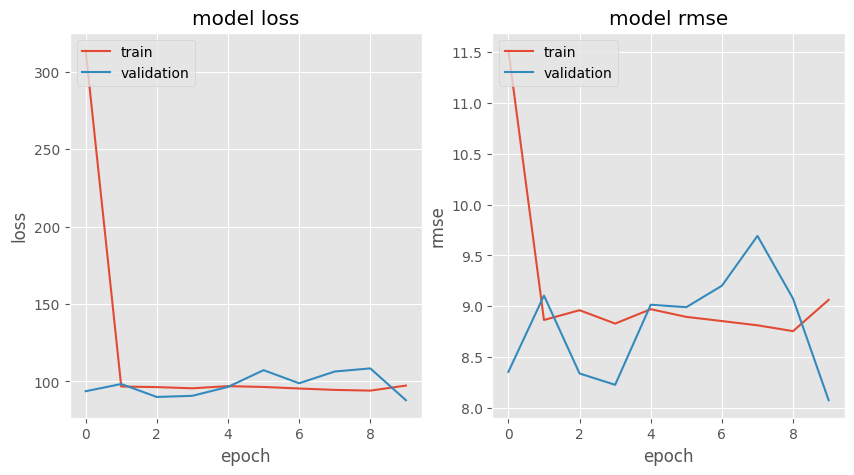

In [39]:
plot_curves(base_history, ['loss', 'rmse'])

In [40]:
base_test_loss, base_test_rmse, base_test_mse = base_model.evaluate(test_dataset)

print(f"Test Loss: {base_test_loss}") 
print(f"Test RMSE: {base_test_rmse}")

980/980 [==============================] - 5s 5ms/step - loss: 106.1000 - rmse: 8.9237 - mse: 106.1000
Test Loss: 106.0999755859375
Test RMSE: 8.923748970031738


**Key Takeaways:**
* Although the rmse metric is lower than the standard deviation of the entire dataset dataset, the loss is very high.
* The evaluation metrics also hint that the model seems to be overfitting to the training dataset

**New Approach:**
* New approach: Drop columns that do not seem to impact the fare (datetime column) and scale the latitude and longitude values using a different method
* Created Bucketized & Crossed columns for latitude and longitude

In [99]:
# Final Model Feature Engineering Functions

# Scale latitude and longitude using Sckit-learn's MinMaxScaler
def minmax_scaling(df):
    scaler = MinMaxScaler()
    df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']] = scaler.fit_transform(df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']])
    return df

def standard_scaling(df):
    scaler = StandardScaler()
    df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']] = scaler.fit_transform(df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']])
    return df

def manual_scaling(df):
    df['pickup_longitude'] = df['pickup_longitude'].apply(lambda x: (x + 75)/8)
    df['pickup_latitude'] =  df['pickup_latitude'].apply(lambda x: (x - 40)/8)
    df['dropoff_longitude'] = df['dropoff_longitude'].apply(lambda x: (x + 75)/8)
    df['dropoff_latitude'] = df['dropoff_latitude'].apply(lambda x: (x - 40)/8)
    return df

# Haversine distance between pickup and dropoff location
def haversine_distance(df):

    # Earth's Radius in Kilometers
    radius = 6371

    p_lat = np.radians(df['pickup_latitude'])
    p_long = np.radians(df['pickup_longitude'])
    d_lat = np.radians(df['dropoff_latitude'])
    d_long = np.radians(df['dropoff_longitude'])

    diff_lat = d_lat - p_lat
    diff_long = d_long - p_long

    a = np.sin(diff_lat / 2) ** 2 + np.cos(p_lat) * np.cos(d_lat) * np.sin(diff_long / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    df['distance'] = radius * c

    return df

def manhattan_distance(df):
    df['distance'] = abs(df['dropoff_longitude'] - df['pickup_longitude']) + abs(df['dropoff_latitude'] - df['pickup_latitude'])
    return df

def euclidean_distance(df):
    lon_diff = df['dropoff_longitude'] - df['pickup_longitude']
    lat_diff = df['dropoff_latitude'] - df['pickup_latitude']
    lon_sq = lon_diff * lon_diff
    lat_sq = lat_diff * lat_diff
    
    df['distance'] = np.sqrt(lon_sq + lat_sq)
    
    return df

# Master function for adjusting features
def final_adjust_features(df):
    #df = minmax_scaling(df)
    #df = standard_scaling(df)
    df = manual_scaling(df)
    df = haversine_distance(df)
    #df = manhattan_distance(df)
    #df = euclidean_distance(df)
    df = df.drop(columns=['pickup_datetime','pickup_dayoftheweek','passenger_count', 'day_Friday', 'day_Monday','day_Saturday','day_Sunday', 'day_Thursday', 'day_Tuesday', 'day_Wednesday', 'pickup_year'])
    df = df.astype(np.float32)
    return df

In [100]:
# Apply feature engineering functions to data and drop columns that do not seem to impact the fare amount
final_df = all_df.copy(deep=True)
final_df = final_adjust_features(final_df)
final_df

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance
0,11.300000,0.125122,0.092393,0.126204,0.089733,0.319296
1,7.700000,0.126570,0.091153,0.127623,0.094830,0.425375
2,10.500000,0.127183,0.091966,0.130650,0.097299,0.707333
3,16.200001,0.124757,0.092563,0.135769,0.094820,1.249912
4,33.500000,0.125829,0.094173,0.142387,0.091612,1.863159
...,...,...,...,...,...,...
10471,13.000000,0.126125,0.095051,0.125694,0.090590,0.498311
10472,8.500000,0.130176,0.096528,0.128499,0.095688,0.208583
10473,8.100000,0.124060,0.090751,0.125316,0.094348,0.423606
10474,13.300000,0.124193,0.092443,0.128318,0.099423,0.901519


In [101]:
# Separate features and labels
# Split dataset into train, test, and validation datasets (proportions: 0.7, 0.15, 0.15)

y = final_df['fare_amount'].copy()
X = final_df.drop(columns=['fare_amount'])

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)

In [102]:
# Convert each dataframe to Tensorflow Datasets
train_dataset = to_dataset(X_train, y_train, shuffle=True)
valid_dataset = to_dataset(X_valid, y_valid)
test_dataset = to_dataset(X_test, y_test)

In [103]:
BUCKETS = 10
FEATURES = list(X.columns)
FEATURES

['pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'distance']

In [104]:
# Model Development
def final_model(b, od, du):
    inputs = {
        colname: layers.Input(name=colname, shape=(1,), dtype='float32')
        for colname in FEATURES
    }

    latbuckets = np.linspace(0, 1, b).tolist()
    lonbuckets = np.linspace(0, 1, b).tolist()
    pickup_lon_buckets = layers.experimental.preprocessing.Discretization(bin_boundaries=lonbuckets)(inputs['pickup_longitude'])
    pickup_lat_buckets = layers.experimental.preprocessing.Discretization(bin_boundaries=latbuckets)(inputs['pickup_latitude'])
    dropoff_lon_buckets = layers.experimental.preprocessing.Discretization(bin_boundaries=lonbuckets)(inputs['dropoff_longitude'])
    dropoff_lat_buckets = layers.experimental.preprocessing.Discretization(bin_boundaries=latbuckets)(inputs['dropoff_latitude'])

    crossed_features = layers.Concatenate()([
        pickup_lon_buckets,
        pickup_lat_buckets,
        dropoff_lon_buckets,
        dropoff_lat_buckets
    ])

    embedding_layer = layers.Embedding(input_dim=b ** 4, output_dim=od)
    embedded_features = embedding_layer(crossed_features)
    flattened_features = layers.Flatten()(embedded_features)

    distance = layers.Dense(du, activation='relu')(inputs['distance'])

    combined_features = layers.Concatenate()([
        flattened_features,
        distance
    ])

    h1 = layers.Dense(64, activation='relu', name='h1')(combined_features)
    h2 = layers.Dense(32, activation='relu', name='h2')(h1)
    #h3 = layers.Dense(16, activation='relu', name='h3')(h2)
    #h4 = layers.Dense(8, activation='relu', name='h4')(h3)
    
    output = layers.Dense(1, activation='linear', name='fare')(h2)

    model = models.Model(
        inputs=[inputs['pickup_latitude'], inputs['pickup_longitude'], inputs['dropoff_latitude'], inputs['dropoff_longitude'], inputs['distance']],
        outputs=output
    )

    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])
    return model

In [105]:
model = final_model(10,100,100)

In [106]:
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 pickup_longitude (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 pickup_latitude (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 dropoff_longitude (InputLayer)  [(None, 1)]         0           []                               
                                                                                                  
 dropoff_latitude (InputLayer)  [(None, 1)]          0           []                               
                                                                                           

In [107]:
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=20, steps_per_epoch=(len(X_train) // 16))

Epoch 1/20
453/453 [==============================] - 9s 18ms/step - loss: 43.9734 - rmse: 5.1922 - mse: 43.9734 - val_loss: 23.9652 - val_rmse: 3.5799 - val_mse: 23.9652
Epoch 2/20
453/453 [==============================] - 8s 18ms/step - loss: 19.9816 - rmse: 3.6033 - mse: 19.9816 - val_loss: 24.2761 - val_rmse: 3.6541 - val_mse: 24.2761
Epoch 3/20
453/453 [==============================] - 8s 18ms/step - loss: 19.2213 - rmse: 3.5592 - mse: 19.2213 - val_loss: 25.1944 - val_rmse: 3.6994 - val_mse: 25.1944
Epoch 4/20
453/453 [==============================] - 8s 18ms/step - loss: 20.1296 - rmse: 3.6074 - mse: 20.1296 - val_loss: 23.4141 - val_rmse: 3.5673 - val_mse: 23.4141
Epoch 5/20
453/453 [==============================] - 8s 18ms/step - loss: 19.4352 - rmse: 3.5734 - mse: 19.4352 - val_loss: 24.4532 - val_rmse: 3.6494 - val_mse: 24.4532
Epoch 6/20
453/453 [==============================] - 8s 18ms/step - loss: 19.0861 - rmse: 3.5518 - mse: 19.0861 - val_loss: 23.2359 - val_rmse: 

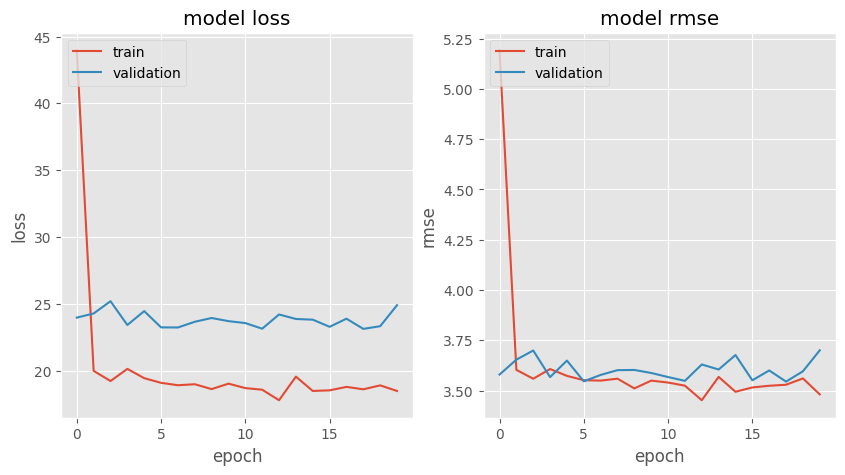

In [108]:
plot_curves(history, ['loss', 'rmse'])

In [109]:
test_loss, test_rmse, test_mse = model.evaluate(test_dataset)

980/980 [==============================] - 3s 3ms/step - loss: 35.6619 - rmse: 3.8724 - mse: 35.6619


In [110]:
all_rmse = []
all_loss = []

for i in np.arange(0,15):
    print("Test Number: ", i)
    model = final_model(10, 100, 100)
    history = model.fit(train_dataset, validation_data=valid_dataset, epochs=20, steps_per_epoch=(len(X_train) // 16))
    
    test_loss, test_rmse, test_mse = model.evaluate(test_dataset)
    
    all_rmse.append(test_rmse)
    all_loss.append(test_loss)
    
    print("Test Loss: ", test_loss)
    print("Test RMSE: ",  test_rmse)
    print("______________________")
    
avg_rmse = np.mean(all_rmse)
avg_loss = np.mean(all_loss)
print("Mean RMSE: ", avg_rmse)
print("Mean Loss: ", avg_loss)

Test Number:  0
Epoch 1/20
453/453 [==============================] - 10s 18ms/step - loss: 39.5121 - rmse: 4.8998 - mse: 39.5121 - val_loss: 25.4361 - val_rmse: 3.6995 - val_mse: 25.4361
Epoch 2/20
453/453 [==============================] - 8s 18ms/step - loss: 20.0389 - rmse: 3.6245 - mse: 20.0389 - val_loss: 23.4004 - val_rmse: 3.5732 - val_mse: 23.4004
Epoch 3/20
453/453 [==============================] - 8s 18ms/step - loss: 19.7469 - rmse: 3.5710 - mse: 19.7469 - val_loss: 24.1201 - val_rmse: 3.5934 - val_mse: 24.1201
Epoch 4/20
453/453 [==============================] - 8s 18ms/step - loss: 19.4532 - rmse: 3.6037 - mse: 19.4532 - val_loss: 23.2683 - val_rmse: 3.5432 - val_mse: 23.2683
Epoch 5/20
453/453 [==============================] - 8s 18ms/step - loss: 19.4035 - rmse: 3.5907 - mse: 19.4035 - val_loss: 24.0634 - val_rmse: 3.6031 - val_mse: 24.0634
Epoch 6/20
453/453 [==============================] - 8s 18ms/step - loss: 19.2550 - rmse: 3.5847 - mse: 19.2550 - val_loss: 23.